# Coursera Capstone Project - Battle of the Neighbourhood<a name='top'></a>
## Hongfang Lu

## Table of Contents
* [Introduction](#intro)
* [Data](#data)
 - [London](#data-london)
 - [Moscow](#data-moscow)
 - [San Francisco](#data-sanfra)
 - [Collecting Venues](#venues)
* [Methodology](#method)
* [Analysis](#ana)
* [Results and Discussion](#res-dis)
* [Conclusion](#conclusion)

## Introduction <a name='intro'></a>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

This project will utilize data scraped using Foursquare api to create visualization and do machine learning analysis. Three cities, London, Moscow and San Francisco are explored and analyzed. Different types of venues are collected, i.e. dining places, gyms, entertainment places, drinking places (coffee and bar) and so on. The geographical results are shown using Folium.

In [150]:
import pandas as pd
import scipy
import numpy as np
import folium
from folium import plugins
import requests
import re
import os
import pickle
import math

from itertools import cycle

from tqdm import tqdm
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim #convert address to latitude and longitude
from geopy import distance as ll_distance

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import country_converter as coco # country to continent convertion
from hdx.location.country import Country # restaurant category to country name convertion


import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.preprocessing import StandardScaler

# requires wkhtmltopdf
import imgkit 

print('Libraries imported.')

Libraries imported.


## Data<a name='data'></a>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

The raw data of the project is scraped using beatifulsoup from the following three Wikipedia pages, 
[**London**](https://en.wikipedia.org/wiki/List_of_areas_of_London)
[**Moscow**](https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow)
[**San Francisco**](https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Francisco)

The neighbourhoods, areas and boroughs (in Moscow they are named differently) are scraped and formatted. The areas include their latitude and longitude information in their respective pages. The format of geographical coordinates are in different styles, such as ‘1’37°45’16”N  122°27’33” or “37.76424°N 122.42366°W”. A cleansing of the formats are done so that the latitudes and longitudes are all in decimal formats with positive signs (N, E) and negative signs (S, W).

The formatted geometrical coordinates are fed into the foursquare api to generate recommended venues. All the areas/neighbourhoods/locations form a web and a Delaunay analysis is performed to find out the average distance between the vortices. This distance is used as the radius parameter in the foursquare api, so that as many as venues can be generated/captured.

### 1. Get London neighbourhoods information<a name='data-london'></a>

Get the list of areas in London through wikipedia page.

In [151]:
page_london = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')
page_london

<Response [200]>

Using Beautiful Soup to find the table that contains the neighbourhoods information.

In [152]:
soup = BeautifulSoup(page_london.content, 'html.parser')
tables = soup.find_all('table', {'class': 'wikitable'})

Get the columns of the table, then remove all space (or unicode non-breaking sign), replace them with underscores.

In [153]:
columns_row = tables[0].tbody.contents[0].children
columns_name = []
for co in columns_row:
    if co != '\n':
        #print(co.text)
        columns_name.append(co.text)

columns_name = map(lambda x: x.replace(u'\xa0', '_')
                   .replace(' ', '_').strip() 
                   if isinstance(x, (str, bytes)) 
                   else x, columns_name)

Get the columns names.

In [154]:
columns_name = list(columns_name)
print(columns_name)

['Location', 'London_borough', 'Post_town', 'Postcode_district', 'Dial_code', 'OS_grid_ref']


Get the rows for each neighbourhood from the parsed webpage. The result is saved so that it can be loaded directly when the script is run for later uses. The folder for data is under `/Data` folder.

In [155]:
locations = tables[0].tbody.contents[1:]

try:
    with open(os.path.join(os.curdir, 'Data', 'london_raw.pkl'), 'rb') as infile:
        all_data = pickle.load(infile)
        print('london raw data is loaded.')
except:
    all_data = []
    for location in tqdm(locations):
        if location != '\n':
            #print(location)
            loc_data = []
            for co in location:
                if co != '\n':
                    #print(co.contents[0])
                    try: 
                        urll = co.contents[0]['href']
                        loc_data.append(urll)
                        loc_data.append(co.text.strip())
                    except:
                        loc_data.append(co.text.strip())
            all_data.append(loc_data)
    
    with open(os.path.join(os.curdir, 'Data', 'london_raw.pkl'), 'wb') as outfile:
        pickle.dump(all_data, outfile)
        print('london raw data is scraped and saved.')

london raw data is loaded.


The number of neighbourhoods in London is 533.

In [156]:
len(all_data)

533

These two utility functions transforms the coordinates to decimal.

the function `process_lan_lat()` transforms the coordinates from the form of '1.23N, 0.33W' into a list of the latitudes and longitudes, in the form of \[1.23, -0.33\]. 
the function `lat_long_to_dec()` transforms the coordinates from the form of """  37°12'12"S 122°45'23"W   """ into a list of the latitudes and longitudes, in the form of \[37.2033, 12.756389\]. The difference lies in whether to take care of the degree (°), minute ('), and second (") symbol.

In [157]:
def process_lan_lat(strn):
    strn = strn.strip()
    N_sign = True
    E_sign = True
    
    lat_p = strn.find('N')
    if lat_p == -1:
        N_sign = False
        lat_p = strn.find('S')
    
    lon_p = strn.find('E')
    if lon_p == -1:
        E_sign = False
        lon_p = strn.find('W')
    
    lat = strn[:(lat_p - 1)]
    lon = strn[(lat_p + 2):(lon_p - 1)]
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]


def lat_long_to_dec(strn):
    strn = strn.strip()
    restemp = re.split('[°\'"′″ ]+', strn)
    
    #print(restemp)
    
    N_sign = 'N' in restemp
    E_sign = 'E' in restemp
    
    #print([N_sign, E_sign])
    
    if N_sign:
        lat_p = restemp.index('N')
    else:
        lat_p = restemp.index('S')
    
    if E_sign:
        lon_p = restemp.index('E')
    else:
        lon_p = restemp.index('W')
    
    #print([lat_p, lon_p])
    
    if lat_p == 1:
        lat = float(restemp[0])
    elif lat_p == 2:
        lat = float(restemp[0]) + float(restemp[1]) / 60
    elif lat_p == 3:
        lat = float(restemp[0]) + float(restemp[1]) / 60 + \
            float(restemp[2]) / 3600
    else:
        raise Exception('Wrong latitude format.')
    
    if (lon_p - lat_p) == 2:
        lon = float(restemp[lat_p + 1])
    elif (lon_p - lat_p) == 3:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60
    elif (lon_p - lat_p) == 4:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60 + \
            float(restemp[lat_p + 3]) / 3600
    else:
        raise Exception('Wrong longitude format.')
    
    #print([lat, lon])
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]

Parse wikipedia pages of each neighbourhood, then get the geograpical coordinate. Result is saved as well.

In [158]:
%%time

try:
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_london.pkl'), 'rb') as infile:
        lat_lon_all = pickle.load(infile)
        print('london lat lon is loaded.')
except:
    lat_lon_all = [None for i in range(len(all_data))]

    for i in tqdm(range(len(all_data))):
        urll = 'https://en.wikipedia.org' + all_data[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dec'})
        if len(lls) > 0:
            #print(all_data[i][1])
            #print(lls[0].text)

            lat_lon_all[i] = str(lls[0].text)
    
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_london.pkl'), 'wb') as outfile:
        pickle.dump(lat_lon_all, outfile)
        print('london lat lon is scraped and saved.')


london lat lon is loaded.
Wall time: 6 ms


Transform the geographical coordinates into lists.

In [159]:
%%time
for i in range(len(all_data)):
    if lat_lon_all[i]:
        lat_lon = process_lan_lat(lat_lon_all[i])
    else:
        lat_lon = [None, None]
    
    all_data[i].extend(lat_lon)

Wall time: 1 ms


Create the dataframe.

In [160]:
london_df = pd.DataFrame(all_data, columns=['Link'] + columns_name + ['Latitude', 'Longitude'])
london_df.head()

Link     Location                     London_borough  \
0           /wiki/Abbey_Wood   Abbey Wood             Bexley,  Greenwich [1]   
1        /wiki/Acton,_London        Acton  Ealing, Hammersmith and Fulham[2]   
2    /wiki/Addington,_London    Addington                         Croydon[2]   
3           /wiki/Addiscombe   Addiscombe                         Croydon[2]   
4  /wiki/Albany_Park,_Bexley  Albany Park                             Bexley   

        Post_town Postcode_district Dial_code OS_grid_ref   Latitude  \
0          LONDON               SE2       020    TQ465785  51.486400   
1          LONDON            W3, W4       020    TQ205805  51.513519   
2         CROYDON               CR0       020    TQ375645  51.358300   
3         CROYDON               CR0       020    TQ345665  51.381000   
4  BEXLEY, SIDCUP         DA5, DA14       020    TQ478728  51.426400   

   Longitude  
0   0.110900  
1  -0.270661  
2  -0.030500  
3  -0.066300  
4   0.102600

There are some rows that don't have the latitude/longitude information, which is line 109 and 355.

In [161]:
london_df[london_df['Latitude'].isnull()]

Link Location London_borough Post_town Postcode_district  \
109  /wiki/Colyers_(ward)  Colyers         Bexley     ERITH               DA8   
355            /wiki/Oval     Oval        Lambeth    LONDON    SW8, SW9, SE11   

    Dial_code OS_grid_ref  Latitude  Longitude  
109     01322    TQ512768       NaN        NaN  
355       020    TQ315575       NaN        NaN

Remove the rows with NaN values.

In [162]:
london_df.dropna(axis=0, inplace=True)

In [163]:
london_df.shape

(531, 9)

In [164]:
address = 'London, England'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

london_lon_lat = [latitude, longitude]

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [165]:
london = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

for lat, lng, borough, neighborhood in zip(london_df['Latitude'], \
                                           london_df['Longitude'], \
                                           london_df['London_borough'], \
                                           london_df['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london)  
    
london

### 2. Get Moscow information<a name='data-moscow'></a>

The same approached used in London is applied to Moscow too.
All intermediate results are saved for later uses. The folder for data is under `/Data` folder.

In [166]:
page_mos = requests.get('https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow')
page_mos

<Response [200]>

In [167]:
soup_mos = BeautifulSoup(page_mos.content, 'html.parser')
tables_mos = soup_mos.find_all('div', attrs={"aria-labelledby": "Administrative_divisions_of_Moscow"})

In [168]:
tables_mos_det = tables_mos[0].table.tbody.contents[1:11]

In [169]:
listss = tables_mos_det[0].td.find_all('li')
listss[0].text

'Arbat'

In [170]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'moscow_raw.pkl'), 'rb') as infile:
        all_data_mos = pickle.load(infile)
        print('moscow raw data is loaded.')
except:
    all_data_mos = []
    for okrug in tqdm(tables_mos_det):
        okrug_name = okrug.th.text
        okrug_link = okrug.th.a['href']
        divis = []
        for divi in okrug.td.find_all('li'):
            divi_link = divi.a['href']
            divi_name = divi.text
            divis.append([divi_link, divi_name, okrug_link, okrug_name])
        all_data_mos.extend(divis)
        
    with open(os.path.join(os.curdir, 'Data', 'moscow_raw.pkl'), 'wb') as outfile:
        pickle.dump(all_data_mos, outfile)
        print('moscow raw data is scraped and loaded.')

moscow raw data is loaded.
Wall time: 10 ms


In [171]:
len(all_data_mos)

125

In [172]:
%%time

try:
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_moscow.pkl'), 'rb') as infile:
        lat_lon_all_mos = pickle.load(infile)
        print('moscow lat lon is loaded.')
except:
    lat_lon_all_mos = [None for i in range(len(all_data_mos))]

    for i in tqdm(range(len(all_data_mos))):
        urll = 'https://en.wikipedia.org' + all_data_mos[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dec'})
        if len(lls) > 0:
            #print(all_data_mos[i][1])
            #print(lls[0].text)

            lat_lon_all_mos[i] = str(lls[0].text)
            
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_moscow.pkl'), 'wb') as outfile:
        pickle.dump(lat_lon_all_mos, outfile)
        print('moscow lat lon is scraped and saved.')

moscow lat lon is loaded.
Wall time: 10 ms


In [173]:
%%time
for i in range(len(all_data_mos)):
    if lat_lon_all_mos[i]:
        lat_lon = process_lan_lat(lat_lon_all_mos[i])
    else:
        lat_lon = [None, None]
    
    all_data_mos[i].extend(lat_lon)

Wall time: 0 ns


In [174]:
moscow_df = pd.DataFrame(all_data_mos, columns=['Link', 'Location', 'OLink', 'OLocation', 'Latitude', 'Longitude'])
moscow_df.head()

Link      Location  \
0                 /wiki/Arbat_District         Arbat   
1              /wiki/Basmanny_District      Basmanny   
2            /wiki/Khamovniki_District    Khamovniki   
3  /wiki/Krasnoselsky_District,_Moscow  Krasnoselsky   
4           /wiki/Meshchansky_District   Meshchansky   

                                OLink                     OLocation  \
0  /wiki/Central_Administrative_Okrug  Central Administrative Okrug   
1  /wiki/Central_Administrative_Okrug  Central Administrative Okrug   
2  /wiki/Central_Administrative_Okrug  Central Administrative Okrug   
3  /wiki/Central_Administrative_Okrug  Central Administrative Okrug   
4  /wiki/Central_Administrative_Okrug  Central Administrative Okrug   

    Latitude  Longitude  
0  55.751000  37.590000  
1  55.764947  37.671583  
2  55.726110  37.571110  
3  55.778610  37.656390  
4  55.775830  37.627500

In [175]:
moscow_df.dropna(axis=0, inplace=True)
moscow_df.shape

(125, 6)

In [176]:
address = 'Moscow, Russia'

geolocator = Nominatim(user_agent="mos_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(latitude, longitude))

moscow_lon_lat = [latitude, longitude]

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [177]:
moscow = folium.Map(location=moscow_lon_lat, zoom_start=10, control_scale=True)

for lat, lng, borough, neighborhood in zip(moscow_df['Latitude'], \
                                           moscow_df['Longitude'], \
                                           moscow_df['Location'], \
                                           moscow_df['OLocation']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(moscow)  
    
moscow

### 3. Get the neighhourhoods of San Francisco<a name='data-sanfra'></a>

The same approached used in London is applied to San Francisco too.
All intermediate results are saved for later uses. The folder for data is under `/Data` folder.

In [178]:
page_san = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Francisco')
page_san

<Response [200]>

In [179]:
soup_san = BeautifulSoup(page_san.content, 'html.parser')
tables_san = soup_san.find_all('div', attrs={"class": "mw-category"})
tables_san = tables_san[1]
tables_san = tables_san.contents[1:]

In [180]:
tables_san[0].ul.find_all('li')

[<li><a href="/wiki/Alamo_Square,_San_Francisco" title="Alamo Square, San Francisco">Alamo Square, San Francisco</a></li>,
 <li><a href="/wiki/Alta_Plaza" title="Alta Plaza">Alta Plaza</a></li>,
 <li><a href="/wiki/Anza_Vista,_San_Francisco" title="Anza Vista, San Francisco">Anza Vista, San Francisco</a></li>]

In [181]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'sanfra_raw.pkl'), 'rb') as infile:
        all_data_san = pickle.load(infile)
        print('sanfra raw data is loaded.')
except:
    all_data_san = []
    for letters in tqdm(tables_san):
        for loc in letters.ul.find_all('li'):
            loc_name = loc.text
            loc_link = loc.a['href']
            all_data_san.append([loc_link, loc_name])
    with open(os.path.join(os.curdir, 'Data', 'sanfra_raw.pkl'), 'wb') as outfile:
        pickle.dump(all_data_san, outfile)
        print('sanfra raw data is scraped and saved.')
len(all_data_san)

sanfra raw data is loaded.
Wall time: 31 ms


In [182]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_sanfra.pkl'), 'rb') as infile:
        lat_lon_all_san = pickle.load(infile)
        print('sanfra lat lon is loaded.')

except:
    lat_lon_all_san = [None for i in range(len(all_data_san))]

    for i in tqdm(range(len(all_data_san))):
        urll = 'https://en.wikipedia.org' + all_data_san[i][0]
        page = requests.get(urll)

        soup = BeautifulSoup(page.content, 'html.parser')

        lls = soup.find_all('span', {'class': 'geo-dms'})
        if len(lls) > 0:
            #print(all_data_san[i][1])
            #print(lls[0].text)

            lat_lon_all_san[i] = str(lls[0].text)
            
    with open(os.path.join(os.curdir, 'Data', 'lat_lon_sanfra.pkl'), 'wb') as outfile:
        pickle.dump(lat_lon_all_san, outfile)
        print('sanfra lat lon is scraped and saved.')

sanfra lat lon is loaded.
Wall time: 6 ms


In [183]:
%%time
for i in range(len(all_data_san)): 
    if lat_lon_all_san[i]:
        if '°' in lat_lon_all_san[i]:
            lat_lon = lat_long_to_dec(lat_lon_all_san[i])
        else:
            lat_lon = process_lan_lat(lat_lon_all_san[i])
    else:
        lat_lon = [None, None]
    
    all_data_san[i].extend(lat_lon)

Wall time: 1e+03 µs


In [184]:
sanfra_df = pd.DataFrame(all_data_san, columns=['Link', 'Location', 'Latitude', 'Longitude'])
sanfra_df.loc[2, 'Longitude'] = -sanfra_df.loc[2, 'Longitude']
sanfra_df.head()

Link                       Location  \
0    /wiki/Alamo_Square,_San_Francisco    Alamo Square, San Francisco   
1                     /wiki/Alta_Plaza                     Alta Plaza   
2      /wiki/Anza_Vista,_San_Francisco      Anza Vista, San Francisco   
3     /wiki/Balboa_Park,_San_Francisco     Balboa Park, San Francisco   
4  /wiki/Balboa_Terrace,_San_Francisco  Balboa Terrace, San Francisco   

    Latitude   Longitude  
0  37.776389 -122.434722  
1  37.791111 -122.437778  
2  37.780833 -122.443056  
3  37.725000 -122.445000  
4  37.731389 -122.468611

In [185]:
sanfra_df.dropna(axis=0, inplace=True)
sanfra_df.shape

(88, 4)

In [186]:
address = 'San Francisco, United States'

geolocator = Nominatim(user_agent="san_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

sanfra_lon_lat = [latitude, longitude]

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [187]:
sanfra = folium.Map(location=sanfra_lon_lat, zoom_start=12, control_scale=True)

for lat, lng, borough in zip(sanfra_df['Latitude'], \
                                           sanfra_df['Longitude'], \
                                           sanfra_df['Location']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sanfra)  
    
sanfra

## 4. Use foursquare api to collect venue informations on each point <a name='venues'></a>

In [188]:
london_df.reset_index(inplace=True)
moscow_df.reset_index(inplace=True)
sanfra_df.reset_index(inplace=True)

The foursquare credentials are stored in the system environment variables.

In [189]:
import os

CLIENT_ID = os.environ['FS_ID']
CLIENT_SECRET = os.environ['FS_SECRET'] 
VERSION = '20190501'

### London venues
The neighbourhood centers are scattered around, first we need to calculate the average the distances between venues, which will be fed into foursquare api for exploring the neighbourhoods. The Delaunay analysis partitions the area into triangles. By calculating the length of the sides of the triangles, we can find the average distances between each neighbourhood. The average distance is then rounded to be the nearest 600. In the case of London, the average distance is 1800 meters.

In [190]:
coordinates_london = london_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_london)

In [191]:
%%time
london_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_london.loc[p1, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    london_dis.extend([d1, d2, d3])
london_dis_mean = np.floor(np.mean(london_dis) / 600) * 600
print(london_dis_mean)

1800.0
Wall time: 2.24 s


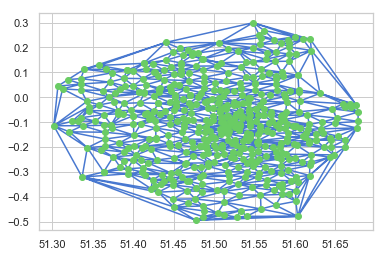

In [192]:
plt.triplot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], 'o')
plt.show()

Then the geographical information is fed into the foursquare api to get the recommended venues in each neighourhood. The data is then saved into the `/Data` folder, for later use.

In [193]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'results_london.pkl'), 'rb') as infile:
        results_london = pickle.load(infile)
        print('results of london loaded.')

except:
    results_london = [None for i in range(london_df.shape[0])]

    radius = london_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, london_df.shape[0])):
        idd = location_id
        sp_name = london_df.loc[idd, 'Location']
        sp_la = london_df.loc[idd, 'Latitude']
        sp_lo = london_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_london[location_id] = result
        #print(str(location_id) + ' is written')
    
    with open(os.path.join(os.curdir, 'Data', 'results_london.pkl'), 'wb') as outfile:
        pickle.dump(results_london, outfile)
        print('results of london scraped and saved.')

results of london loaded.
Wall time: 959 ms


In [194]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Extract the venue types and geographical information.

In [195]:
%%time

try:
    with open(os.path.join(os.curdir, 'Data', 'venues_london.pkl'), 'rb') as infile:
        venues_london = pickle.load(infile)
        print('venues of london loaded.')

except:
    venues_london = [None for i in range(london_df.shape[0])]

    for i in range(london_df.shape[0]):
        #print(i)
        if results_london[i]['response']:
            venues = results_london[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            #print(nearby_venues.shape)

            venues_london[i] = nearby_venues
    with open(os.path.join(os.curdir, 'Data', 'venues_london.pkl'), 'wb') as outfile:
        pickle.dump(venues_london, outfile)
        print('venues of london scraped and saved.')

venues of london loaded.
Wall time: 224 ms


In [196]:
venues_london_total = pd.concat(venues_london, axis=0)
venues_london_total.reset_index(inplace=True, drop=True)
venues_london_total.drop_duplicates(inplace=True)
venues_london_total.shape

(11996, 4)

In [197]:
test_rg = np.random.choice(venues_london_total.shape[0], 1000, replace=False)
test_df = venues_london_total.iloc[test_rg, :]
test_df.head()

name            categories        lat       lng
11803        The Terrace             Gastropub  51.689292 -0.017848
24782  Lee Valley Cinema             Multiplex  51.632897 -0.037391
24291        Genesis Gym  Gym / Fitness Center  51.537300 -0.303738
4123      Brixton Market                Market  51.462412 -0.113626
21261       Krispy Kreme            Donut Shop  51.399826 -0.242136

In [198]:
test1 = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

test_df = venues_london_total.iloc[test_rg, :]
for lat, lng, name, cat in zip(test_df['lat'], \
                                           test_df['lng'], \
                                           test_df['name'], \
                                           test_df['categories']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(test1)  
    
test1

### Moscow Venues

The same is done to Moscow.

In [199]:
coordinates_moscow = moscow_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_moscow)

In [200]:
%%time
moscow_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_moscow.loc[p1, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    moscow_dis.extend([d1, d2, d3])
moscow_dis_mean = np.floor(np.mean(moscow_dis) / 600) * 600
print(moscow_dis_mean)

4200.0
Wall time: 557 ms


In [201]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'results_moscow.pkl'), 'rb') as infile:
        results_moscow = pickle.load(infile)
        print('results of moscow loaded.')

except:
    results_moscow = [None for i in range(moscow_df.shape[0])]

    radius = moscow_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, moscow_df.shape[0])):
        idd = location_id
        sp_name = moscow_df.loc[idd, 'Location']
        sp_la = moscow_df.loc[idd, 'Latitude']
        sp_lo = moscow_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_moscow[location_id] = result
        #print(str(location_id) + ' is written')
    print(str(location_id) + ' is written')
    with open(os.path.join(os.curdir, 'Data', 'results_moscow.pkl'), 'wb') as outfile:
        pickle.dump(results_moscow, outfile)
        print('results of moscow scraped and saved.')

results of moscow loaded.
Wall time: 747 ms


In [202]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'venues_moscow.pkl'), 'rb') as infile:
        venues_moscow = pickle.load(infile)
        print('venues of moscow loaded.')

except:
    venues_moscow = [None for i in range(moscow_df.shape[0])]

    for i in tqdm(range(moscow_df.shape[0])):
        if results_moscow[i]['response']:
            venues = results_moscow[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            #print(nearby_venues.shape)

            venues_moscow[i] = nearby_venues
        
    with open(os.path.join(os.curdir, 'Data', 'venues_moscow.pkl'), 'wb') as outfile:
        pickle.dump(venues_moscow, outfile)
        print('venues of moscow scraped and saved.')

venues of moscow loaded.
Wall time: 85 ms


In [203]:
venues_moscow_total = pd.concat(venues_moscow, axis=0)
venues_moscow_total.reset_index(inplace=True, drop=True)
venues_moscow_total.drop_duplicates(inplace=True)
venues_moscow_total.shape

(4157, 4)

### San Francisco Venues

The same is done to San Francisco.

In [204]:
coordinates_sanfra = sanfra_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_sanfra)

In [205]:
%%time
sanfra_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_sanfra.loc[p1, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    sanfra_dis.extend([d1, d2, d3])
sanfra_dis_mean = np.floor(np.mean(sanfra_dis) / 600) * 600
print(sanfra_dis_mean)

1200.0
Wall time: 308 ms


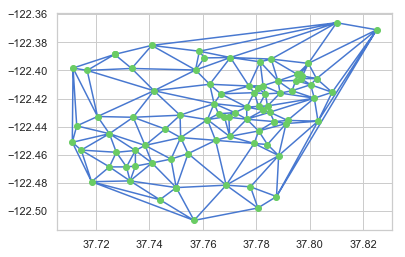

In [206]:
plt.triplot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], 'o')
plt.show()

In [207]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'results_sanfra.pkl'), 'rb') as infile:
        results_sanfra = pickle.load(infile)
        print('results of sanfra loaded.')
        
except:
    results_sanfra = [None for i in range(sanfra_df.shape[0])]

    radius = sanfra_dis_mean
    LIMIT = 200

    for location_id in tqdm(range(0, sanfra_df.shape[0])):
        idd = location_id
        sp_name = sanfra_df.loc[idd, 'Location']
        sp_la = sanfra_df.loc[idd, 'Latitude']
        sp_lo = sanfra_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_sanfra[location_id] = result
        #print(str(location_id) + ' is written')
    print(str(location_id) + ' is written')
    with open(os.path.join(os.curdir, 'Data', 'results_sanfra.pkl'), 'wb') as outfile:
        pickle.dump(results_sanfra, outfile)
        print('results of sanfra scraped and saved.')

results of sanfra loaded.
Wall time: 120 ms


In [208]:
%%time
try:
    with open(os.path.join(os.curdir, 'Data', 'venues_sanfra.pkl'), 'rb') as infile:
        venues_sanfra = pickle.load(infile)
        print('venues of sanfra loaded.')

except:
    venues_sanfra = [None for i in range(sanfra_df.shape[0])]

    for i in tqdm(range(sanfra_df.shape[0])):
        if results_sanfra[i]['response']:
            venues = results_sanfra[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            print(nearby_venues.shape)

            venues_sanfra[i] = nearby_venues
        
    with open(os.path.join(os.curdir, 'Data', 'venues_sanfra.pkl'), 'wb') as outfile:
        pickle.dump(venues_sanfra, outfile)
        print('venues of sanfra scraped and saved.')

venues of sanfra loaded.
Wall time: 46 ms


Total number of venues found

In [209]:
venues_sanfra_total = pd.concat(venues_sanfra, axis=0)
venues_sanfra_total.reset_index(inplace=True, drop=True)
venues_sanfra_total.drop_duplicates(inplace=True)
venues_sanfra_total.shape

(3227, 4)

## Methodology<a name='method'>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

In this project we will use be comparing the similarities between three cities, mainly between San Francisco and London, San Francisco and Moscow. The types of venues are extracted and will be the criteria based on which a recommendation of London or Moscow will be made.
For each city the venues will be divided into several categories. The percentage of each category is calculated and compared across different cities. The top venue types in San Francisco will be the basis of comparison.
Then for the venues in London, a clustering analysis will be performed to see how they are distributed in the city. London has ~12k nodes and is a good example to perform clustering analysis. There are no classification or regression models used in this project. DBSCAN and Birch clustering algorithms are used because they don’t need the number of clusters to begin with. However the geometrical locations are not evenly distributed, which lead to meaningless clustering.


## Analysis<a name='ana'></a>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

### 1. Preliminary analysis on the venue types<a name='ana-pre'></a>

In [210]:
venues_london_total.head(1)

name     categories        lat       lng
0  Lesnes Abbey  Historic Site  51.489526  0.125839

In [211]:
venues_moscow_total.head(1)

name categories        lat        lng
0  Театр им. Вахтангова    Theater  55.749569  37.591638

In [212]:
venues_sanfra_total.head(1)

name categories        lat         lng
0  Alamo Square       Park  37.776062 -122.433622

The venues of all three cities are aggregated into the variable `venues_total_list` for later analysis.

In [213]:
city_names = ['london', 'moscow', 'sanfra']
real_city_names = ['London', 'Moscow', 'San Francisco']
venues_total_list = {'london': venues_london_total, 
                     'moscow': venues_moscow_total, 
                     'sanfra': venues_sanfra_total}
venues_types_plot = {(x + '_types'): None for x in city_names}
venues_types_plot.update({(x + '_groups'): None for x in city_names})

for key, venues_total in venues_total_list.items():
    venue_types = venues_total.categories.unique()
    venue_grouped = venues_total.groupby('categories').count()
    venues_types_plot[key + '_types'] = venue_types
    venues_types_plot[key + '_groups'] = venue_grouped

The top categories of venues in each city is extracted. The top five results are the following:
1. **London** - 
Pub, Coffee Shop, Cafe, Grocery Store, Park
2. **Moscow** - 
Park, Gym / Fitness center, Coffee Shop, Healthy Food Store, Supermarket
3. **San Francisco** - 
Coffee Shop, Park, Cafe, Bakery, Chinese Restaurant

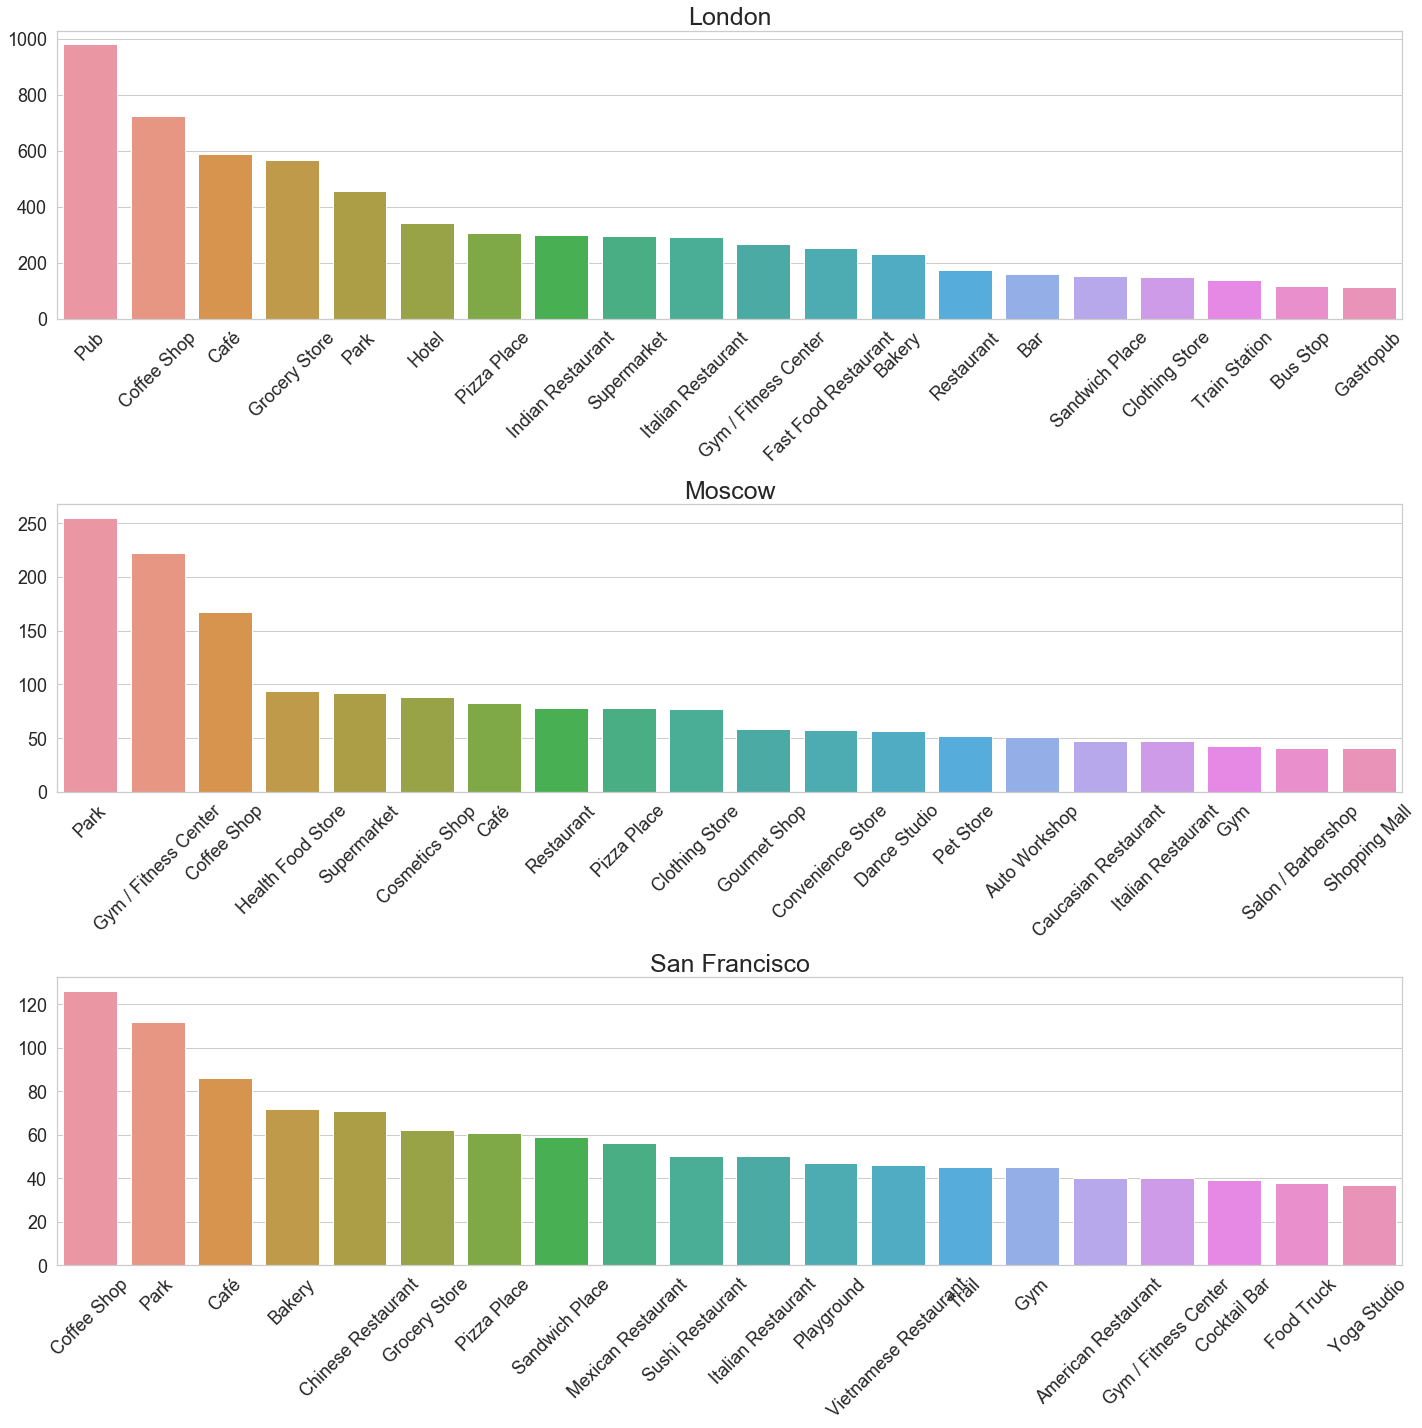

In [214]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
f, axes = plt.subplots(3, 1, figsize=(20, 20))


top_n = 20
for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    plot_data = venues_types_plot[city + '_groups']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
    
    g = sns.barplot(x='categories', y='name', data=plot_data, ax=axes[i])
    g.set_title(real_city, fontsize=25)
    g.tick_params(labelsize=18)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_xticklabels(plot_data['categories'], rotation=45)
plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '1_top_venues_cmp.png'))

One interesting phenomenon is that in Moscow, Gym / fitness center ranked 2nd. And then accordingly, healthy food store tops the food places.

### 2. Get all the categories and analyze

There are all together mainly 6 types,
1. dining places / restaurants / diners
2. bars / pub / coffee
3. fitness / gym / yoga
4. supermarket / grocery store / market
5. cultural sites / museums
6. University / colleges

All categories are extracted from all the data, since different cities might have different types of each large type. So in the end there are 522 unique categories of venues.

In [215]:
# the name of the venues data is venues_total_list
venues_total_list_ana = {'london': venues_london_total, 
                         'moscow': venues_moscow_total, 
                         'sanfra': venues_sanfra_total}
categories_total = []
for venue_temp in venues_total_list_ana.values():
    categories_total.extend(venue_temp['categories'].unique())

categories_total = map(lambda x: x.lower(), categories_total)
categories_total = pd.DataFrame(categories_total, columns=['cat'])
print('number of mixed categories: ' + str(len(categories_total)))

categories_total = categories_total['cat'].unique()
print('number of unique categories: ' + str(len(categories_total)))
categories_total = pd.DataFrame(categories_total, columns=['cat'])

number of mixed categories: 1099
number of unique categories: 522


The categories then is fed through a regex matching algorithm, the majority of the six types covers altogether 250 out of 522 categories.

In [216]:
sub_cats_re = {'dining': r'dining|diner|restauran|eatery|eating|bagel|salad|food|deli|cream|' + 
               r'smoothie|tea|buffet|blini|pelmeni|yoghurt|yogurt|cheese|' + 
               r'breakfast|lunch|dinner|pastry|cupcake',
               'bars': r'bar(?![a-z])|pub|wine|cafe|coffee|bistro|liquor',
               'gym': r'gym|fitness|sport|climb|skating|skate|(?<![a-z])raft' + 
               r'massage|stadium|basketball|baseball|rugby|pool',
               'super': r'supermarket|grocer|fruit|vegetable|market',
               'entertain': r'museum|music|(?<![a-z])art|churck|aquarium|theater|cinema|' + 
               r'entertain|dance|beach|resort|nature|trail|karaoke|zoo|historic|park',
               'school': r'university|college|library|school'
              }

sub_cats = list(sub_cats_re.keys())

sub_cats_dict = {cat:[] for cat in sub_cats}
    

for strn in categories_total['cat']:
    for cat in sub_cats:
        if re.search(sub_cats_re[cat], strn.lower()):
            sub_cats_dict[cat].append(strn)

In [217]:
for cat, res in sub_cats_dict.items():
    print('There are ' + str(len(res)) + ' options in the category: ' + cat)
    print(res[:5])

There are 125 options in the category: dining
['indian restaurant', 'food & drink shop', 'sushi restaurant', 'eastern european restaurant', 'fast food restaurant']
There are 27 options in the category: bars
['pub', 'coffee shop', 'wine shop', 'hookah bar', 'gastropub']
There are 28 options in the category: gym
['gym / fitness center', 'gym', 'stadium', 'rugby pitch', 'sports club']
There are 8 options in the category: super
['supermarket', 'grocery store', 'farmers market', 'organic grocery', 'market']
There are 41 options in the category: entertain
['historic site', 'park', 'museum', 'music venue', 'movie theater']
There are 13 options in the category: school
['school', 'general college & university', 'university', 'library', 'college soccer field']


the Distribution of six types in the three citys

In [218]:
city_names_1 = ['london', 'moscow', 'sanfra']
real_city_names_1 = ['London', 'Moscow', 'San Francisco']
venues_total_list_1 = {'london': venues_london_total, 
                     'moscow': venues_moscow_total, 
                     'sanfra': venues_sanfra_total}

# the dict used to store the counts and the indices
venues_types_plot_1 = {(x + '_type_counts'): None for x in city_names_1}
venues_types_plot_1.update({(x + '_type_indices'): None for x in city_names_1})

for key, venues_total in venues_total_list_1.items():
    type_counts = {}
    type_indices = {}
    venues_total['lower'] = venues_total['categories'].str.lower()
    for cat_big_name, cat_list in sub_cats_dict.items():
        df_in = venues_total[venues_total['lower'].isin(cat_list)]
        type_counts[cat_big_name] = (df_in.shape[0], df_in.shape[0] / venues_total.shape[0])
        type_indices[cat_big_name] = df_in.index
    
    #print(type_counts)
    venues_types_plot_1[key + '_type_counts'] = type_counts
    venues_types_plot_1[key + '_type_indices'] = type_indices


In [219]:
print(venues_types_plot_1.keys())

dict_keys(['london_type_counts', 'moscow_type_counts', 'sanfra_type_counts', 'london_type_indices', 'moscow_type_indices', 'sanfra_type_indices'])


The six major types in each city is plotted below. It can be seen that dining places takes the majority in all cities, but San Francisco definitely has a higher ratio of food culture. London has the highest ratio of bars (which includes alcoholic and non-alcoholic places), which matches well with their habits of having tea and after noon tea time. As mentioned before, Moscow has a 12.6% gym / fitness related facilities. The goal of this project is to recommend tourists cities that are similar to San Francisco. So the following analysis is mainly focused on dining, bars, entertainments and gyms.

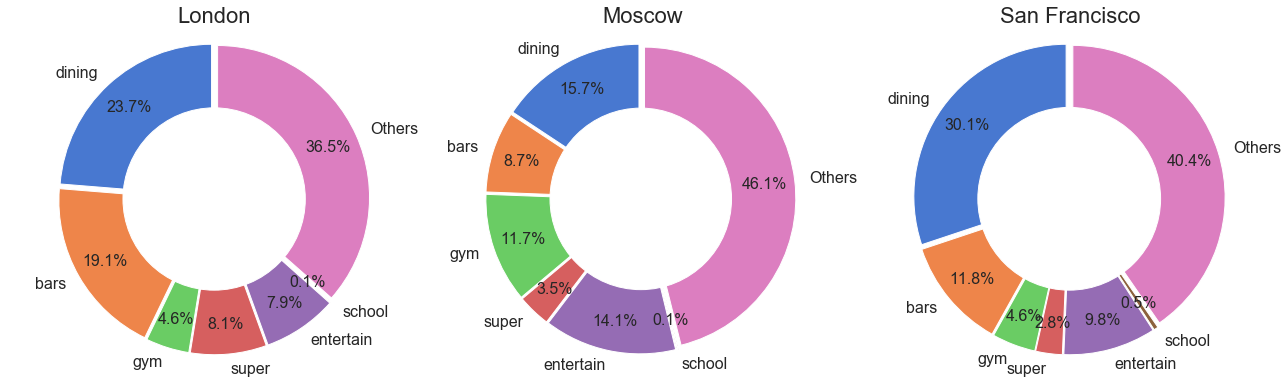

In [220]:
f, axes = plt.subplots(1, 3, figsize=(18, 5.5))

for i in range(len(city_names_1)):
    plt.subplot(1, 3, i + 1)
    real_city = real_city_names[i]
    city = city_names[i]
    
    labels = []
    sizes = []
    for cat, v in venues_types_plot_1[city + '_type_counts'].items():
        labels.append(cat)
        sizes.append(v[1])
    labels.append('Others')
    sizes.append(1 - sum(sizes))
    
    colors = sns.color_palette("muted")[:len(labels)]

    explode = [0.025 for x in range(len(labels))]

    g = plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', 
                startangle=90, pctdistance=0.8, labeldistance=1.1, explode=explode, 
               textprops={'fontsize': 16})
    plt.title(real_city, fontsize=22)
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.60, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    fig.gca().axis('equal')  
plt.tight_layout()
plt.show()
f.savefig(os.path.join(os.curdir, 'Pics', '2_six_categories_cmp.png'))

## 7. Analyze the distribution and stats of restaurants

Since restaurants are the most important aspect of a city, it will be carefully examined.

In [221]:
city_names_2 = ['london', 'moscow', 'sanfra']
dining_data = {}
cat = 'dining'
for key in city_names_2:
    dining_data[key + '_dining_id'] = venues_types_plot_1[key + '_type_indices'][cat]

In [222]:
dining_data_grouped = {}
for i in range(len(city_names_2)):
    city = city_names_2[i]
    real_city = real_city_names[i]
    test_df = venues_total_list_ana[city].loc[dining_data[city + '_dining_id'], :]
    test_df_grouped = test_df.groupby(['lower']).count()
    test_df_grouped.reset_index(inplace=True)
    dining_data_grouped[city + '_dining_grouped'] = test_df_grouped
dining_data_grouped[city + '_dining_grouped'].head()

lower  name  categories  lat  lng
0       afghan restaurant     1           1    1    1
1      african restaurant     2           2    2    2
2     american restaurant    40          40   40   40
3        arepa restaurant     1           1    1    1
4  argentinian restaurant     3           3    3    3

The top 5 restaurants in the cities are,
* **London** - Indian, Italian, Fast Food, Turkish, Chinese
* **Moscow** - Health Food, Italian, Caucasian, Fast Food
* **San Francisco** - Chinese, Mexican, Italian, Sushi, Vietnamese

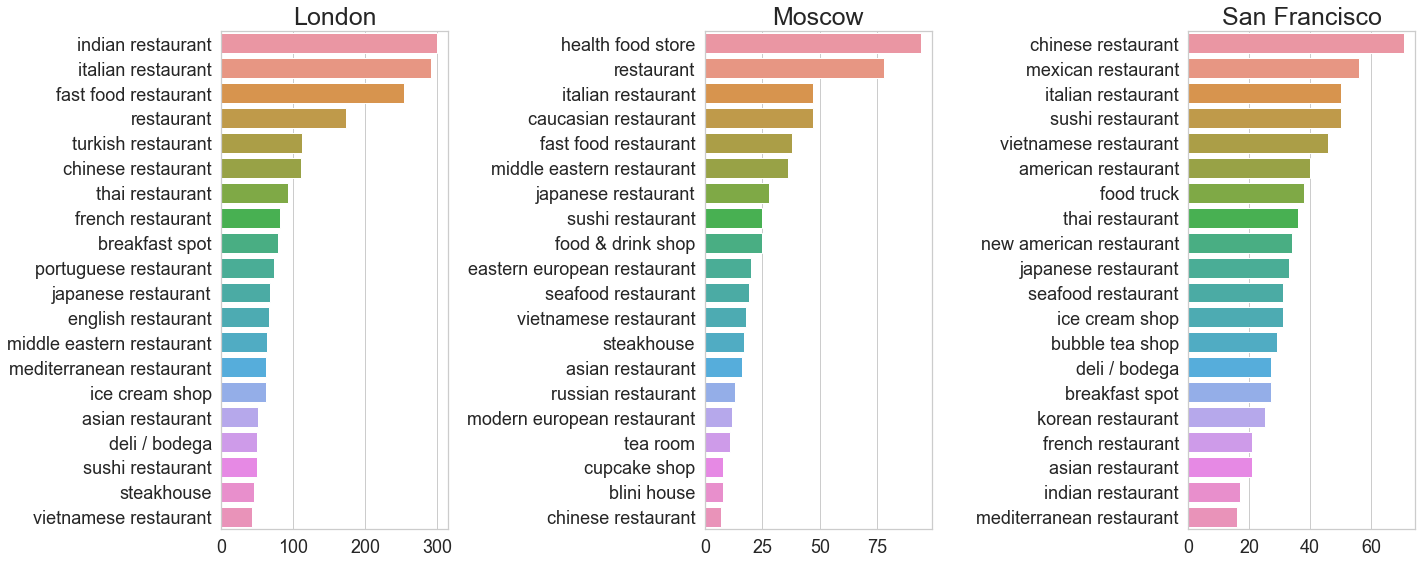

In [223]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1, 3, figsize=(20, 8))


top_n = 20
for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    plot_data = dining_data_grouped[city + '_dining_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
    g = sns.barplot(y='lower', x='name', data=plot_data, ax=axes[i])
    g.set_title(real_city, fontsize=25)
    g.tick_params(labelsize=18)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_yticklabels(plot_data['lower'])
    #print(g.get_position())
    #g.tick_params(labeltop=True, labelbottom=False)
plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '3_top_rest_cmp.png'))

In [224]:
top_sanfra_df = dining_data_grouped['sanfra' + '_dining_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
top_sanfra_rest_types = top_sanfra_df['lower']

From the result we can see, London is more similar to San Francisco in the number of restaurants.

The disctribution of Chinese, Suchi, Italian, Mexican, vietnamese restaurant in San Francisco.

In [225]:
top_five_rest = plot_data['lower'][:5]
top_five_rest_big_dict = {}

for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    test_df = venues_total_list_ana[city].loc[dining_data[city + '_dining_id'], :]
    
    top_five_rest_plot_data = {}
    for rest_type in top_five_rest:
        x = test_df[test_df['lower'] == rest_type]
        top_five_rest_plot_data[rest_type] = x
    top_five_rest_big_dict[city] = top_five_rest_plot_data

In [226]:
# the distribution of top five restaurants in San Francisco

top_rest_sanfra = folium.Map(location=sanfra_lon_lat, zoom_start=13, control_scale=True)
city = 'sanfra'

colors = ['red', 'green', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_sanfra)

for indd, rest_type in enumerate(top_five_rest):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(top_rest_sanfra)

legend_html =   '''
                <div style="position: fixed; top: 50px; 
                right: 50px; width: 200px; height: 140px; 
                border:5px solid #DDDDDD; z-index:9999; font-size:14px; background-color:#DDDDDD; opacity:0.7">
                &nbsp; Restaurant Types&nbsp; ''' + \
                '''<br><i class="fa fa-circle" style="color:red"></i>&nbsp; ''' + str(top_five_rest[0]) + \
                '''&nbsp; <br><i class="fa fa-circle" style="color:green"></i>&nbsp; ''' + str(top_five_rest[1]) + \
                '''&nbsp; <br><i class="fa fa-circle" style="color:blue"></i>&nbsp; ''' + str(top_five_rest[2]) + \
                '''&nbsp; <br><i class="fa fa-circle" style="color:pink"></i>&nbsp; ''' + str(top_five_rest[3]) + \
                '''&nbsp; <br><i class="fa fa-circle" style="color:purple"></i>&nbsp; ''' + str(top_five_rest[4]) + \
                '''</div>''' 

top_rest_sanfra.get_root().html.add_child(folium.Element(legend_html))
top_rest_sanfra

In [227]:
# the distribution of top Chinese restaurants in London
london_chinese = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)
city = 'london'

colors = ['red', 'darkblue', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_london)

for indd, rest_type in enumerate(top_five_rest[:1]):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(london_chinese)

london_chinese

In [228]:
# the distribution of top Chinese restaurants in Moscow
moscow_chinese = folium.Map(location=moscow_lon_lat, zoom_start=10, control_scale=True)
city = 'moscow'

colors = ['red', 'darkblue', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_london)

for indd, rest_type in enumerate(top_five_rest[:1]):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(moscow_chinese)

moscow_chinese

In [229]:
# the distribution of top Mexican restaurants in London
london_mexican = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)
city = 'london'

colors = ['red', 'darkblue', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_london)

for indd, rest_type in enumerate(top_five_rest[1:2]):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(london_mexican)

london_mexican

In [230]:
top_five_rest_big_dict['moscow']['mexican restaurant']

Empty DataFrame
Columns: [name, categories, lat, lng, lower]
Index: []

there is no mexican restaurants in Moscow

In [231]:
# the distribution of top Italian restaurants in London
london_italian = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)
city = 'london'

colors = ['red', 'darkblue', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_london)

for indd, rest_type in enumerate(top_five_rest[2:3]):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(london_italian)

london_italian

In [232]:
# the distribution of top Italian restaurants in moscow
moscow_italian = folium.Map(location=moscow_lon_lat, zoom_start=11, control_scale=True)
city = 'moscow'

colors = ['red', 'darkblue', 'blue', 'pink', 'purple']
#incidents = plugins.MarkerCluster().add_to(top_rest_moscow)

for indd, rest_type in enumerate(top_five_rest[2:3]):
    for lat, lng, name in zip(top_five_rest_big_dict[city][rest_type]['lat'], 
                                   top_five_rest_big_dict[city][rest_type]['lng'], 
                                   top_five_rest_big_dict[city][rest_type]['name']):
        label = '{}, {}'.format(name, rest_type)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colors[indd],
            fill=True,
            fill_color=colors[indd],
            fill_opacity=0.8,
            parse_html=False).add_to(moscow_italian)

moscow_italian

The apparent lack of Chinese restaurants and absence of Mexican restaurants in Moscow has its historical reasons. Moscow has only 0.03% / 3222 Chinese people as of 2010, and almost no Mexican people. So there are no Mexican restaurants. In consideration of the inaccuracy of this project there are actually a few mexcian restaurants according to google maps. However indeed there is not a lot (only 19). Italian restaurants are popular in every country, so the result is not surprising.

## 8. Analyze the clustering of Italian restaurants in London

In [233]:
city = 'london'
rest_type = top_five_rest[2]
london_italian_rest_df = top_five_rest_big_dict[city][rest_type]
london_italian_rest_df.shape
X = london_italian_rest_df[['lng', 'lat']]

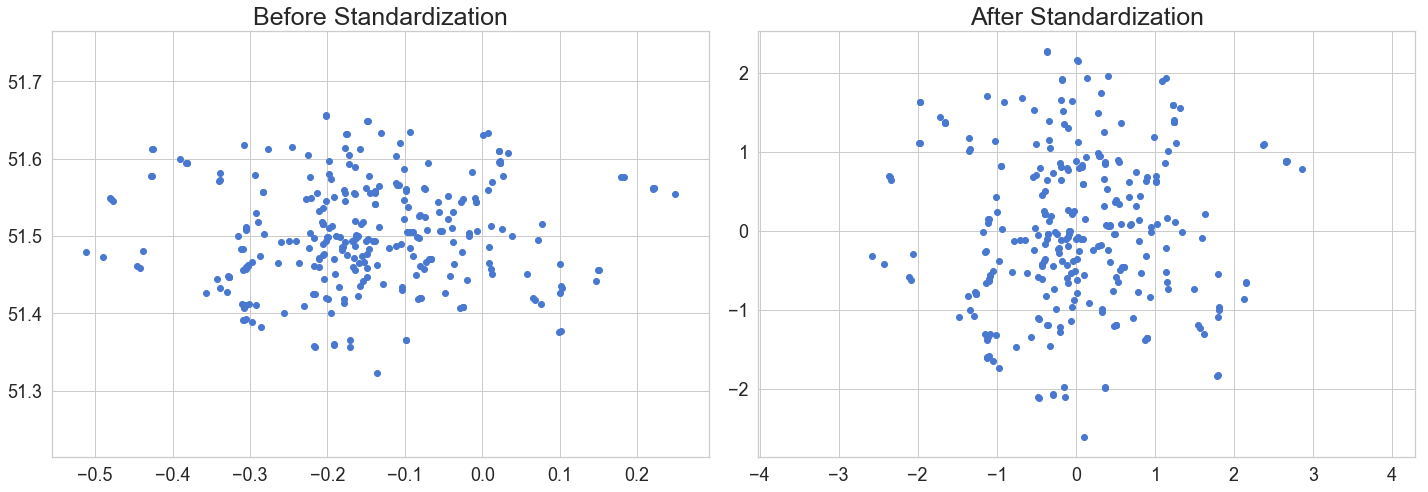

In [234]:
f, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].scatter(X['lng'], X['lat'])
axes[0].tick_params(labelsize=18)
axes[0].set_title('Before Standardization', fontsize=25)
axes[0].axis('equal')

X = StandardScaler().fit_transform(X)
axes[1].scatter(X[:, 0], X[:, 1])
axes[1].tick_params(labelsize=18)
axes[1].set_title('After Standardization', fontsize=25)
axes[1].axis('equal')

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '4_italian_standardization.png'))
plt.show()

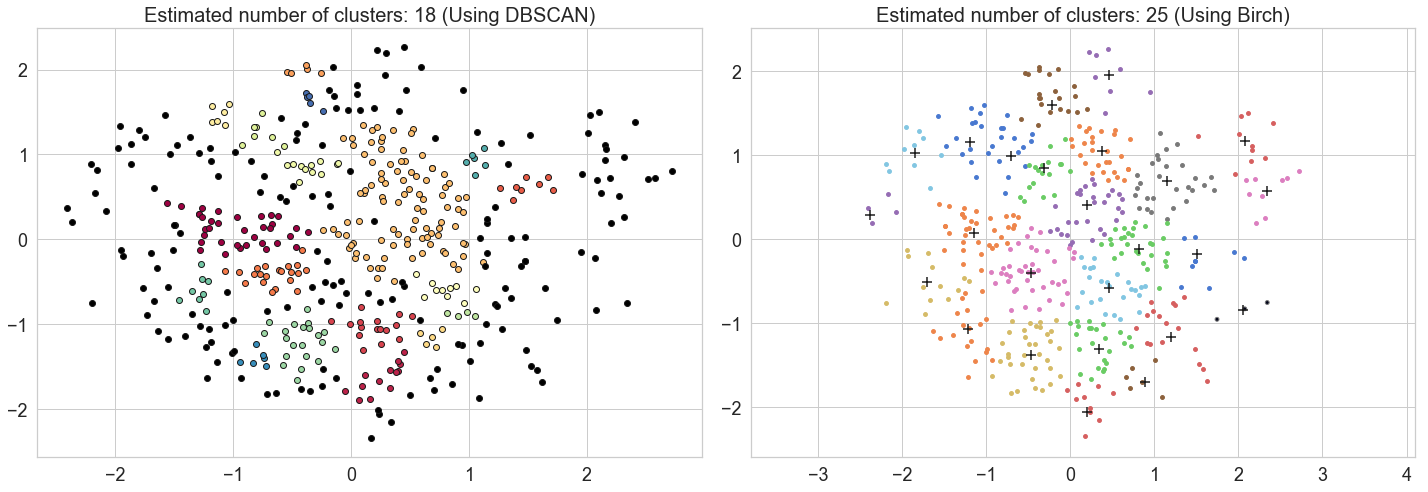

In [259]:
db = DBSCAN(eps=0.18).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

f, axes = plt.subplots(1, 2, figsize=(20, 7))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
axes[0].tick_params(labelsize=18)
axes[0].set_title('Estimated number of clusters: %d (Using DBSCAN)' % n_clusters_, fontsize=20)



birch_model = Birch(threshold=0.4, n_clusters=None)
birch_model.fit(X)
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size

colors_ = cycle(sns.color_palette("muted"))

for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
    mask = labels == k
    axes[1].scatter(X[mask, 0], X[mask, 1],
               c=col, edgecolor=col, marker='.', alpha=1, s=60)
    axes[1].scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=90)
axes[1].tick_params(labelsize=18)
axes[1].axis('equal') 
axes[1].set_title('Estimated number of clusters: %d (Using Birch)' % n_clusters, fontsize=20)

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '5_italian_cluster.png'))
plt.show()

## 9. Analyze the Distribution and Stats of Drinking Places in Three cities

In [236]:
city_names_3 = ['london', 'moscow', 'sanfra']
bars_data = {}
cat = 'bars'
for key in city_names_3:
    bars_data[key + '_bars_id'] = venues_types_plot_1[key + '_type_indices'][cat]

In [237]:
bars_data_grouped = {}
for i in range(len(city_names_2)):
    city = city_names_2[i]
    real_city = real_city_names[i]
    test_df = venues_total_list_ana[city].loc[bars_data[city + '_bars_id'], :]
    test_df_grouped = test_df.groupby(['lower']).count()
    test_df_grouped.reset_index(inplace=True)
    bars_data_grouped[city + '_bars_grouped'] = test_df_grouped
bars_data_grouped[city + '_bars_grouped'].head()

lower  name  categories  lat  lng
0           bar    35          35   35   35
1      beer bar    10          10   10   10
2        bistro     1           1    1    1
3  cocktail bar    39          39   39   39
4   coffee shop   126         126  126  126

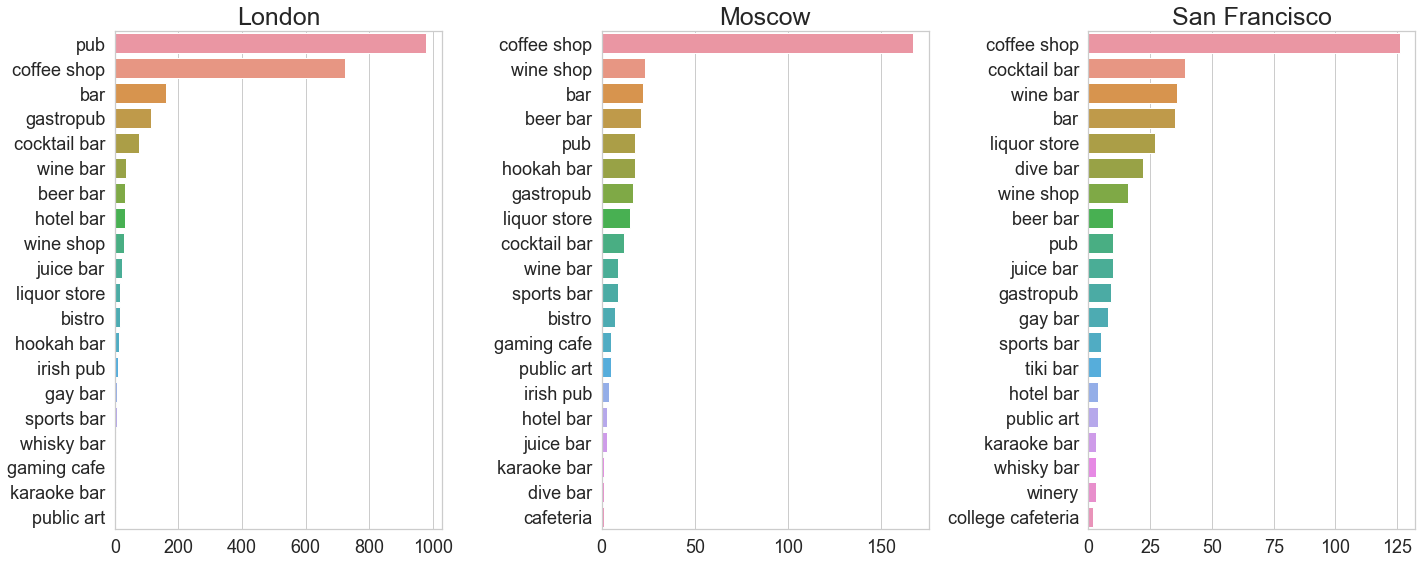

In [238]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1, 3, figsize=(20, 8))


top_n = 20
for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    plot_data = bars_data_grouped[city + '_bars_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
    g = sns.barplot(y='lower', x='name', data=plot_data, ax=axes[i])
    g.set_title(real_city, fontsize=25)
    g.tick_params(labelsize=18)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_yticklabels(plot_data['lower'])
    #print(g.get_position())
    #g.tick_params(labeltop=True, labelbottom=False)
plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '6_top_bars_cmp.png'))

Coffee is import in western world, from this aspect all cities has really high ratio of coffee shops. However Moscow has relatively fewer coffee shops because out of its ~4k venues only ~150 are coffee shops. Different bars and pubs in all cities are similar, but London and San Francisco has more in common.

## 10. Analyze the clustering of Coffee Shops in London

In [239]:
top_sanfra_bars_df = bars_data_grouped['sanfra' + '_bars_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
top_sanfra_bars_types = top_sanfra_bars_df['lower']

In [240]:
top_five_bars = plot_data['lower'][:5]
top_five_bars_big_dict = {}

for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    test_df = venues_total_list_ana[city].loc[bars_data[city + '_bars_id'], :]
    
    top_five_bars_plot_data = {}
    for bars_type in top_five_bars:
        x = test_df[test_df['lower'] == bars_type]
        top_five_bars_plot_data[bars_type] = x
    top_five_bars_big_dict[city] = top_five_bars_plot_data

In [241]:
city = 'london'
bar_type = 'coffee shop'
london_coffee_shop_df = top_five_bars_big_dict[city][bar_type]
london_coffee_shop_df.shape
X = london_coffee_shop_df[['lng', 'lat']]

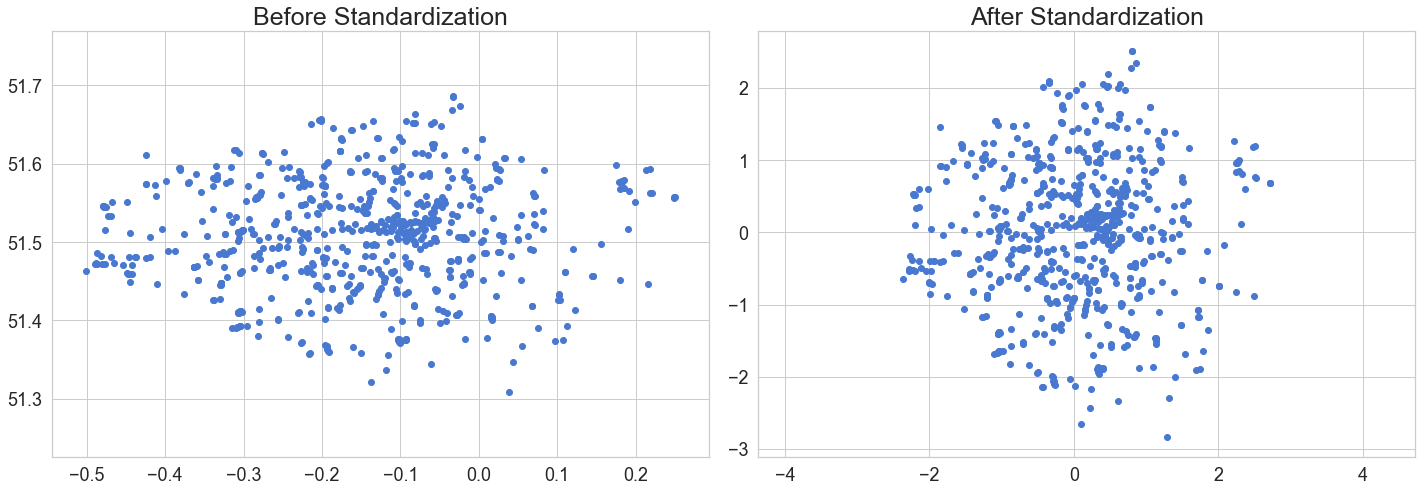

In [242]:
f, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].scatter(X['lng'], X['lat'])
axes[0].tick_params(labelsize=18)
axes[0].set_title('Before Standardization', fontsize=25)
axes[0].axis('equal')

X = StandardScaler().fit_transform(X)
axes[1].scatter(X[:, 0], X[:, 1])
axes[1].tick_params(labelsize=18)
axes[1].set_title('After Standardization', fontsize=25)
axes[1].axis('equal')

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '7_coffee_shop_standardization.png'))
plt.show()

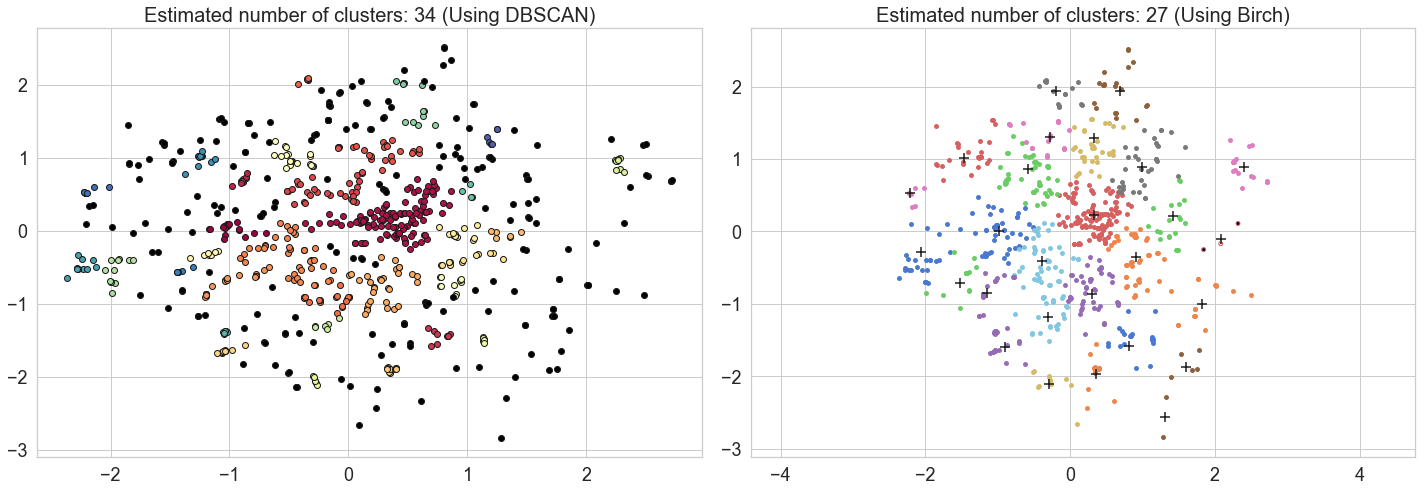

In [243]:
db = DBSCAN(eps=0.15).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

f, axes = plt.subplots(1, 2, figsize=(20, 7))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
axes[0].tick_params(labelsize=18)
axes[0].set_title('Estimated number of clusters: %d (Using DBSCAN)' % n_clusters_, fontsize=20)



birch_model = Birch(threshold=0.4, n_clusters=None)
birch_model.fit(X)
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size

colors_ = cycle(sns.color_palette("muted"))

for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
    mask = labels == k
    axes[1].scatter(X[mask, 0], X[mask, 1],
               c=col, edgecolor=col, marker='.', alpha=1, s=60)
    axes[1].scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=90)
axes[1].tick_params(labelsize=18)
axes[1].axis('equal') 
axes[1].set_title('Estimated number of clusters: %d (Using Birch)' % n_clusters, fontsize=20)

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '8_coffee_cluster.png'))
plt.show()

## 11. Analyze the Distribution and Stats of Entertainments in Three cities

In [244]:
city_names_3 = ['london', 'moscow', 'sanfra']
ente_data = {}
cat = 'entertain'
for key in city_names_3:
    ente_data[key + '_ente_id'] = venues_types_plot_1[key + '_type_indices'][cat]

In [245]:
ente_data_grouped = {}
for i in range(len(city_names_2)):
    city = city_names_2[i]
    real_city = real_city_names[i]
    test_df = venues_total_list_ana[city].loc[ente_data[city + '_ente_id'], :]
    test_df_grouped = test_df.groupby(['lower']).count()
    test_df_grouped.reset_index(inplace=True)
    ente_data_grouped[city + '_ente_grouped'] = test_df_grouped
ente_data_grouped[city + '_ente_grouped'].head()

lower  name  categories  lat  lng
0          art gallery    34          34   34   34
1           art museum     7           7    7    7
2  arts & crafts store    13          13   13   13
3                beach     7           7    7    7
4           bike trail     1           1    1    1

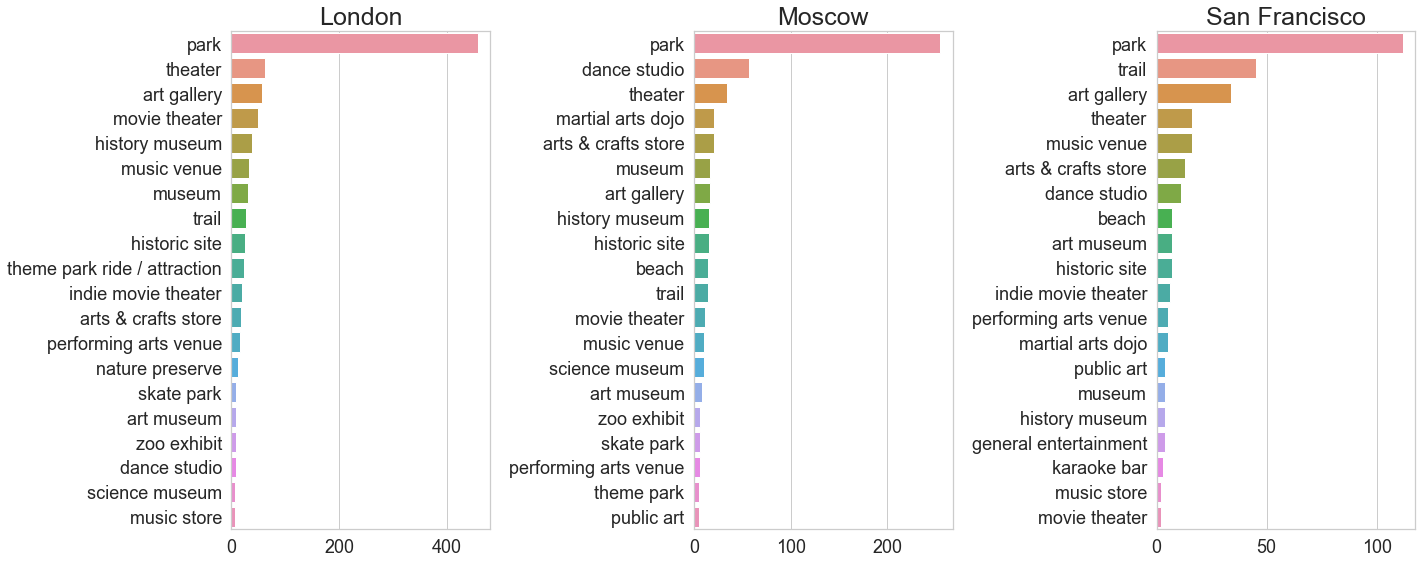

In [246]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1, 3, figsize=(20, 8))


top_n = 20
for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    plot_data = ente_data_grouped[city + '_ente_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
    g = sns.barplot(y='lower', x='name', data=plot_data, ax=axes[i])
    g.set_title(real_city, fontsize=25)
    g.tick_params(labelsize=18)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_yticklabels(plot_data['lower'])
    #print(g.get_position())
    #g.tick_params(labeltop=True, labelbottom=False)
plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '9_top_ente_cmp.png'))

It can be seen that cultural sites are very popular in London, with art gallery and history museum ranking 3rd and 5th place. One observation in San Francisco is that it has trail ranking 2nd place, because the state of California does have a lot of national parks and trails. In Moscow however, dance studio ranks 2nd, which correlates to the fact that they have higher ratio of gyms. Other than that, the three cities have similar ratio of entertainments and distribution of entertainments. Parks, theaters, art galleries, and museums are among some of the most popular ones.

## 13. Analyze the clustering of Parks in London

In [247]:
top_london_ente_df = ente_data_grouped['london' + '_ente_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
top_london_ente_types = top_london_ente_df['lower']

In [248]:
top_five_ente = plot_data['lower'][:5]
top_five_ente_big_dict = {}

for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    test_df = venues_total_list_ana[city].loc[ente_data[city + '_ente_id'], :]
    
    top_five_ente_plot_data = {}
    for ente_type in top_five_ente:
        x = test_df[test_df['lower'] == ente_type]
        top_five_ente_plot_data[ente_type] = x
    top_five_ente_big_dict[city] = top_five_ente_plot_data

In [249]:
city = 'london'
ente_type = 'park'
london_park_df = top_five_ente_big_dict[city][ente_type]
london_park_df.shape
X = london_park_df[['lng', 'lat']]

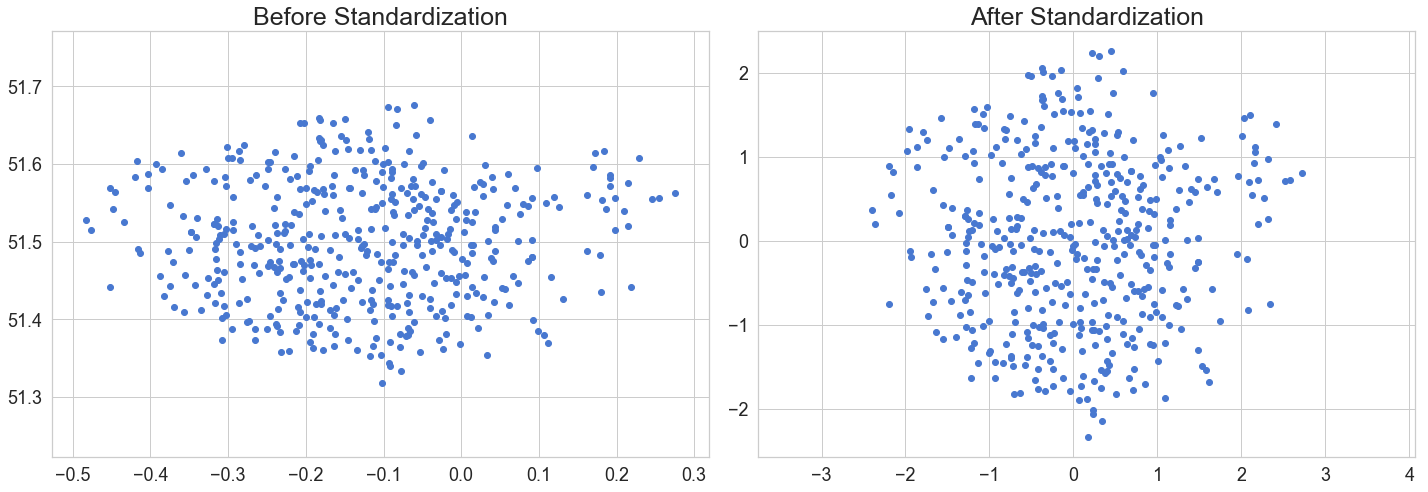

In [250]:
f, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].scatter(X['lng'], X['lat'])
axes[0].tick_params(labelsize=18)
axes[0].set_title('Before Standardization', fontsize=25)
axes[0].axis('equal')

X = StandardScaler().fit_transform(X)
axes[1].scatter(X[:, 0], X[:, 1])
axes[1].tick_params(labelsize=18)
axes[1].set_title('After Standardization', fontsize=25)
axes[1].axis('equal')

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '10_park_standardization.png'))
plt.show()

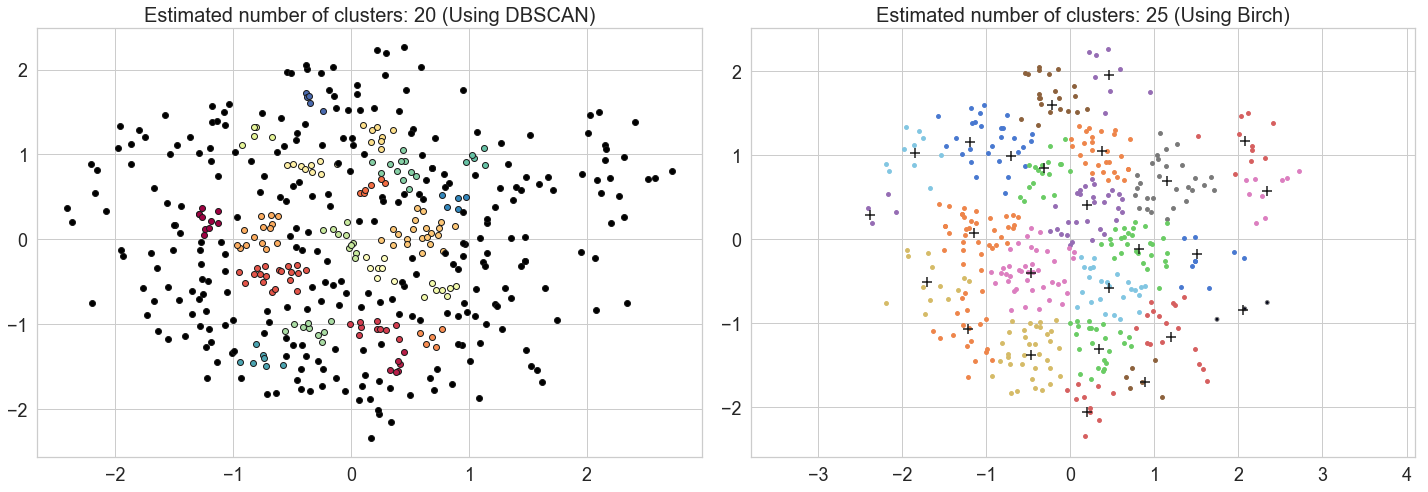

In [251]:
db = DBSCAN(eps=0.15).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

f, axes = plt.subplots(1, 2, figsize=(20, 7))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
axes[0].tick_params(labelsize=18)
axes[0].set_title('Estimated number of clusters: %d (Using DBSCAN)' % n_clusters_, fontsize=20)



birch_model = Birch(threshold=0.4, n_clusters=None)
birch_model.fit(X)
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size

colors_ = cycle(sns.color_palette("muted"))

for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
    mask = labels == k
    axes[1].scatter(X[mask, 0], X[mask, 1],
               c=col, edgecolor=col, marker='.', alpha=1, s=60)
    axes[1].scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=90)
axes[1].tick_params(labelsize=18)
axes[1].axis('equal') 
axes[1].set_title('Estimated number of clusters: %d (Using Birch)' % n_clusters, fontsize=20)

plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '11_park_cluster.png'))
plt.show()

## 14. Analyze the Distribution and Stats of Gyms in Three cities

In [252]:
city_names_3 = ['london', 'moscow', 'sanfra']
gyms_data = {}
cat = 'gym'
for key in city_names_3:
    gyms_data[key + '_gyms_id'] = venues_types_plot_1[key + '_type_indices'][cat]
    
gyms_data_grouped = {}
for i in range(len(city_names_2)):
    city = city_names_2[i]
    real_city = real_city_names[i]
    test_df = venues_total_list_ana[city].loc[gyms_data[city + '_gyms_id'], :]
    test_df_grouped = test_df.groupby(['lower']).count()
    test_df_grouped.reset_index(inplace=True)
    gyms_data_grouped[city + '_gyms_grouped'] = test_df_grouped
gyms_data_grouped[city + '_gyms_grouped'].head()

lower  name  categories  lat  lng
0  athletics & sports     5           5    5    5
1      baseball field    13          13   13   13
2    baseball stadium     3           3    3    3
3    basketball court     3           3    3    3
4  basketball stadium     1           1    1    1

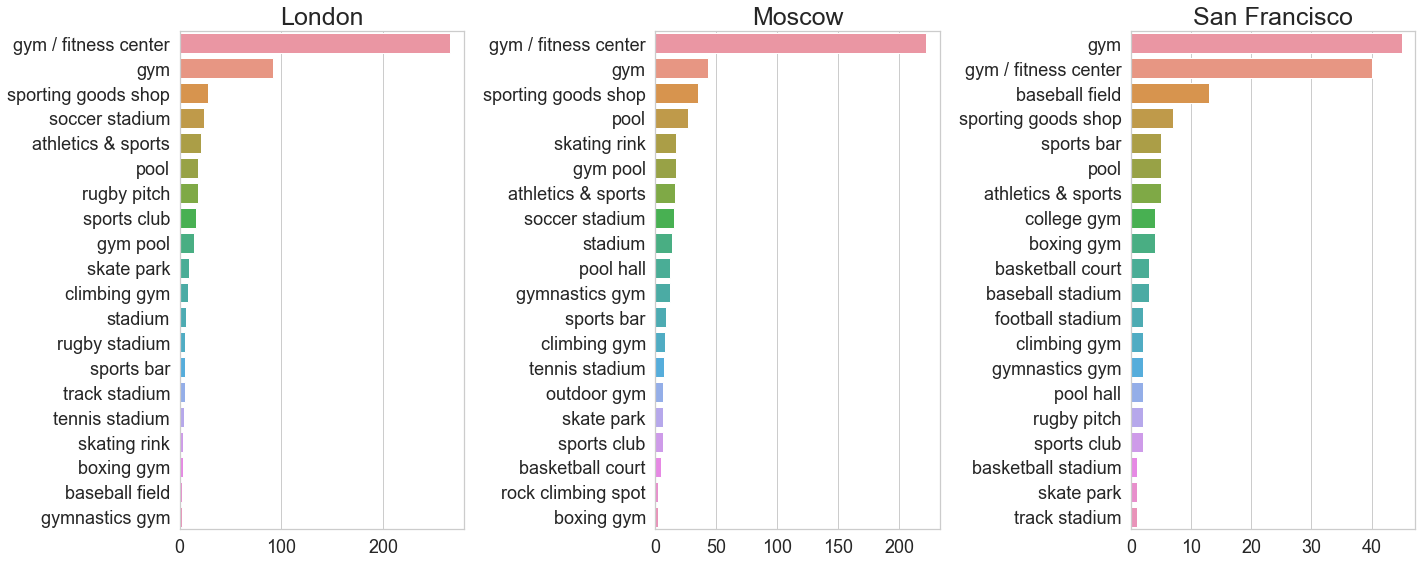

In [253]:
sns.set(style='whitegrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1, 3, figsize=(20, 8))


top_n = 20
for i in range(len(city_names)):
    real_city = real_city_names[i]
    city = city_names[i]
    plot_data = gyms_data_grouped[city + '_gyms_grouped']\
        .sort_values(['name'], axis=0, ascending=False).reset_index().head(top_n)
    g = sns.barplot(y='lower', x='name', data=plot_data, ax=axes[i])
    g.set_title(real_city, fontsize=25)
    g.tick_params(labelsize=18)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_yticklabels(plot_data['lower'])
    #print(g.get_position())
    #g.tick_params(labeltop=True, labelbottom=False)
plt.tight_layout()
f.savefig(os.path.join(os.curdir, 'Pics', '12_top_gyms_cmp.png'))

It can be seen that even though Moscow only has ~4k total venues, compared to London’s ~12k total venues, it has relatively the same amount of fitness related venues. London has its characteristic fitness place, soccer stadium, and Moscow has skating rink ranking 5th in the distribution, which is due to the cultural and climate difference. San Francisco has baseball field in the 3rd place apparently due to the popularity of baseball in the United States.

## Results and Conclusion <a name='res-dis'></a>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

From above results we can see, the distribution of restaurants in London is more similar to San Francisco compared to Moscow. There are historical and cultural reasons. Also London has a more diverse racial distribution compared to Moscow. For travelling in a city, restaurants are definitely important. From this aspect London should be a better choice compared to Moscow if the tourist has travelled in San Francisco already.
Drinking places and entertainments has similar distribution in these three cities, with a slightly different emphasis. London people showed their love for coffee and drinks, while Moscow people have a higher preference on fitness and gyms. Gyms are not an important aspect when it comes to travelling, however if one decides to live in Moscow, it might be a good and healthy choice.
From the above analysis, we can see the distribution of dining places, drinking places and entertainments are actually related to the culture, climate and racial distribution.


## Conclusion<a name='conclusion'></a>
[Introduction](#intro)
[Data](#data)
[Methodology](#method)
[Analysis](#ana)
[Results and Discussion](#res-dis)
[Conclusion](#conclusion)
[back to top](#top)

Through a thorough analysis of venues in all three cities, **I recommend London for people who have travelled in San Francisco before**. The similar analysis can be done to other cities. Further quantity related analysis can be done, for example number of restaurants around metro stations and hotels.